##音への反応を可視化
前までfailureを機器のエラーによるNAと理解していたが、
マウスがレバーを引かなかったものと理解して修正した

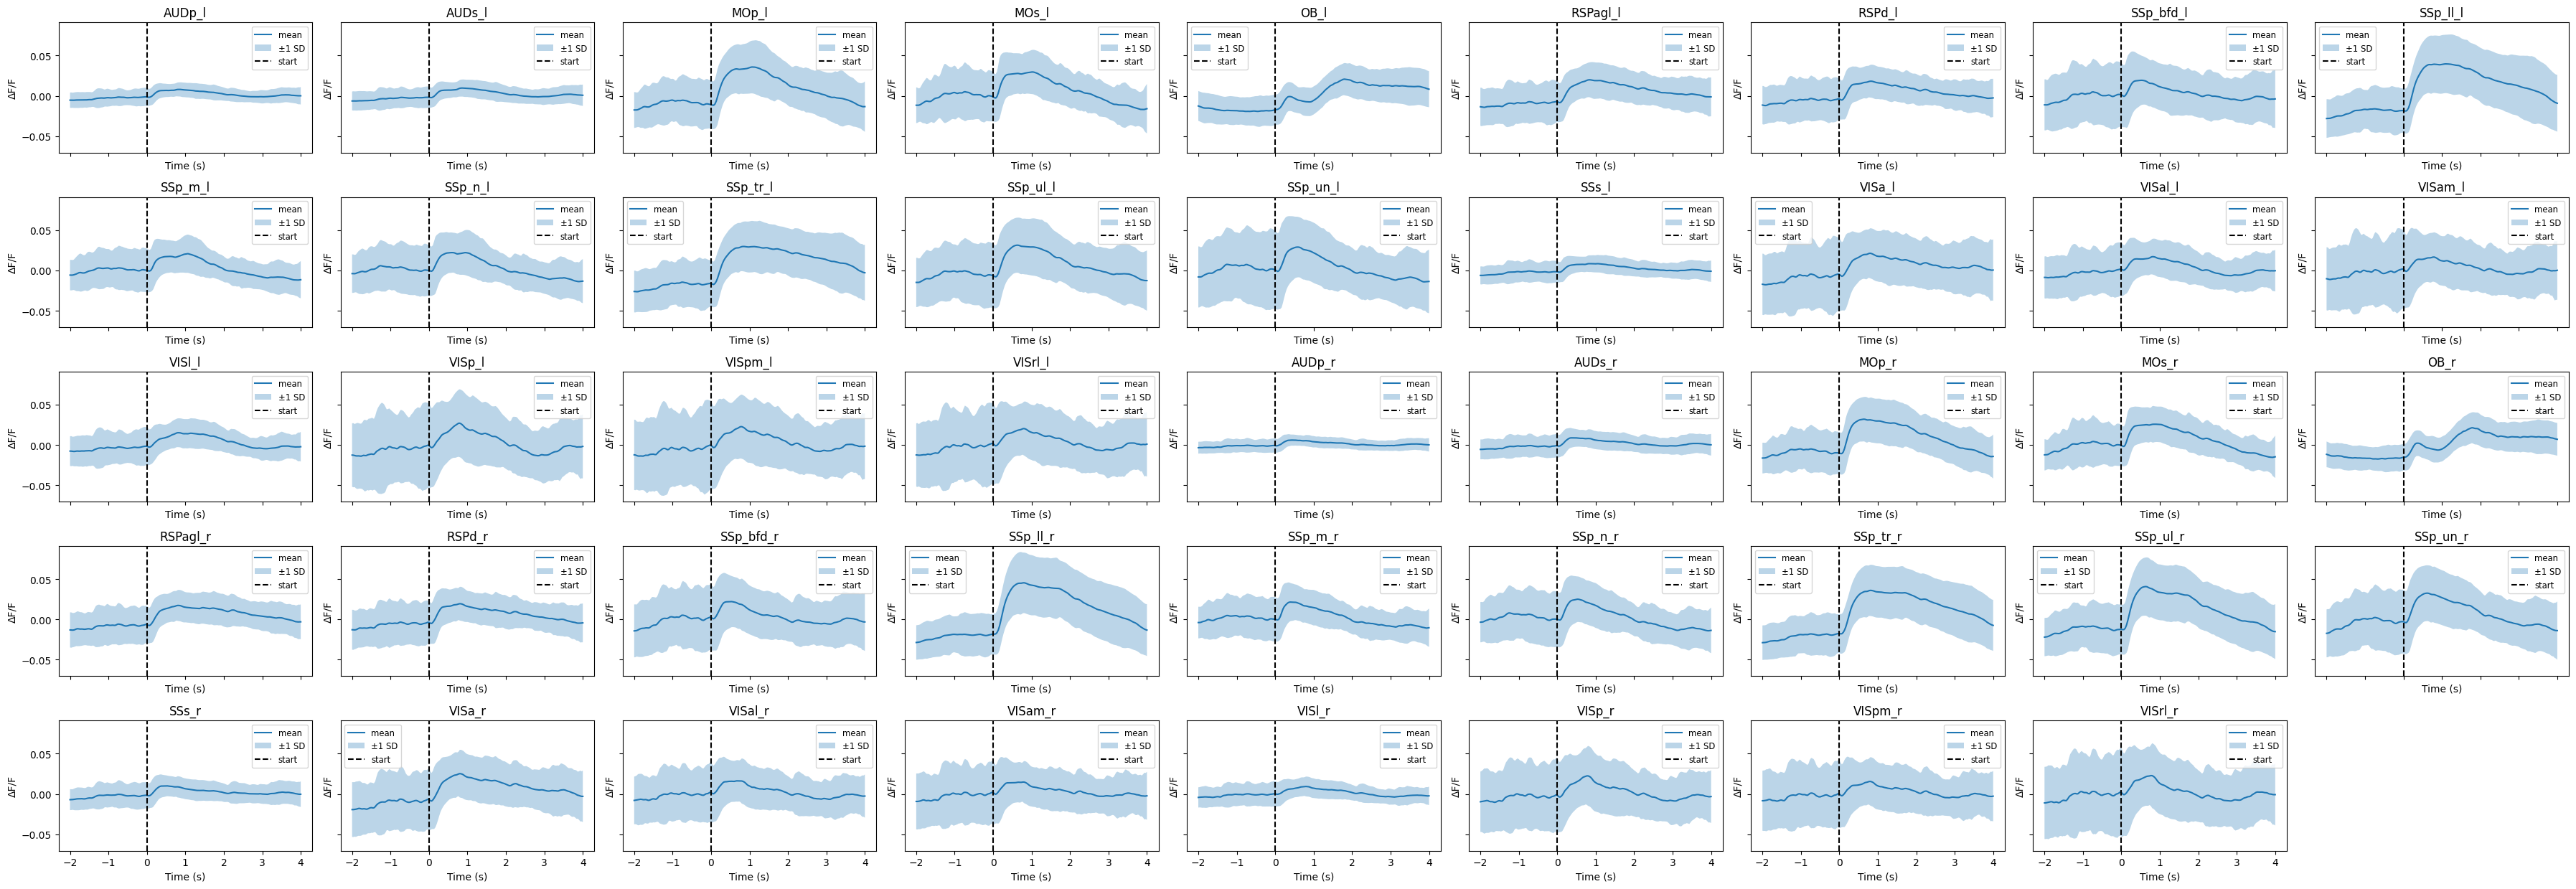

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# # --- データ読み込み ---
# csv_path = Path('/content/drive/MyDrive/VG1GC-105/VG1GC-105/task-day8/trials_L1L2.csv')
# trials = pd.read_csv(csv_path)

# dataroot = Path('/content/drive/MyDrive/braidyn-bc/data')
# testfile = dataroot / "VG1GC-105" / "VG1GC-105_2024-02-02_task-day8.nwb"
# session = nwbx.read_nwb(testfile)
# all_rois = session.imaging.data
# imaging_t = all_rois.index.to_numpy()

# === パラメータ ===
fs = 30  # 30Hz
pre_time  = 2.0  # 開始前 2秒
post_time = 4.0  # 終了後 4秒
pre_samples  = int(pre_time * fs)
post_samples = int(post_time * fs)
window_len = pre_samples + post_samples + 1
time_axis = (np.arange(window_len) - pre_samples) / fs

# === データ取得 ===
all_rois = session.imaging.data            # index: 時間（秒）, columns: ROI
trial_df = session.trials.data             # DataFrame: 各試行の情報
imaging_t = all_rois.index.to_numpy()      # NumPy配列化して検索高速化

# === ROIごとに試行ごとの時系列を保存 ===
roi_trials = {roi: [] for roi in all_rois.columns}

for trial_start in trial_df['start_time']:
    idx0 = np.searchsorted(imaging_t, trial_start)
    start_idx = idx0 - pre_samples
    end_idx   = idx0 + post_samples
    if start_idx < 0 or end_idx >= len(imaging_t):
        continue  # 範囲外はスキップ
    window = all_rois.iloc[start_idx:end_idx+1]
    for roi in all_rois.columns:
        roi_trials[roi].append(window[roi].values)

# === 平均と標準偏差を計算 ===
roi_mean = {}
roi_std = {}
for roi, trial_list in roi_trials.items():
    if len(trial_list) == 0:
        continue
    arr = np.stack(trial_list)  # shape = (n_trials, window_len)
    roi_mean[roi] = np.nanmean(arr, axis=0)
    roi_std[roi]  = np.nanstd(arr, axis=0)

# === サブプロット表示 ===
n_rois = len(roi_mean)
n_cols = 9
n_rows = ceil(n_rois / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*2.5), sharex=True, sharey=True)
axes = axes.flatten()

for ax, roi in zip(axes, roi_mean.keys()):
    ax.plot(time_axis, roi_mean[roi], label='mean')
    ax.fill_between(time_axis,
                    roi_mean[roi] - roi_std[roi],
                    roi_mean[roi] + roi_std[roi],
                    alpha=0.3, label='±1 SD')
    ax.axvline(0, color='k', linestyle='--', label='start')
    ax.set_title(roi)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('ΔF/F')
    ax.legend(fontsize='small')

# 残りの空白サブプロットを非表示
for ax in axes[n_rois:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


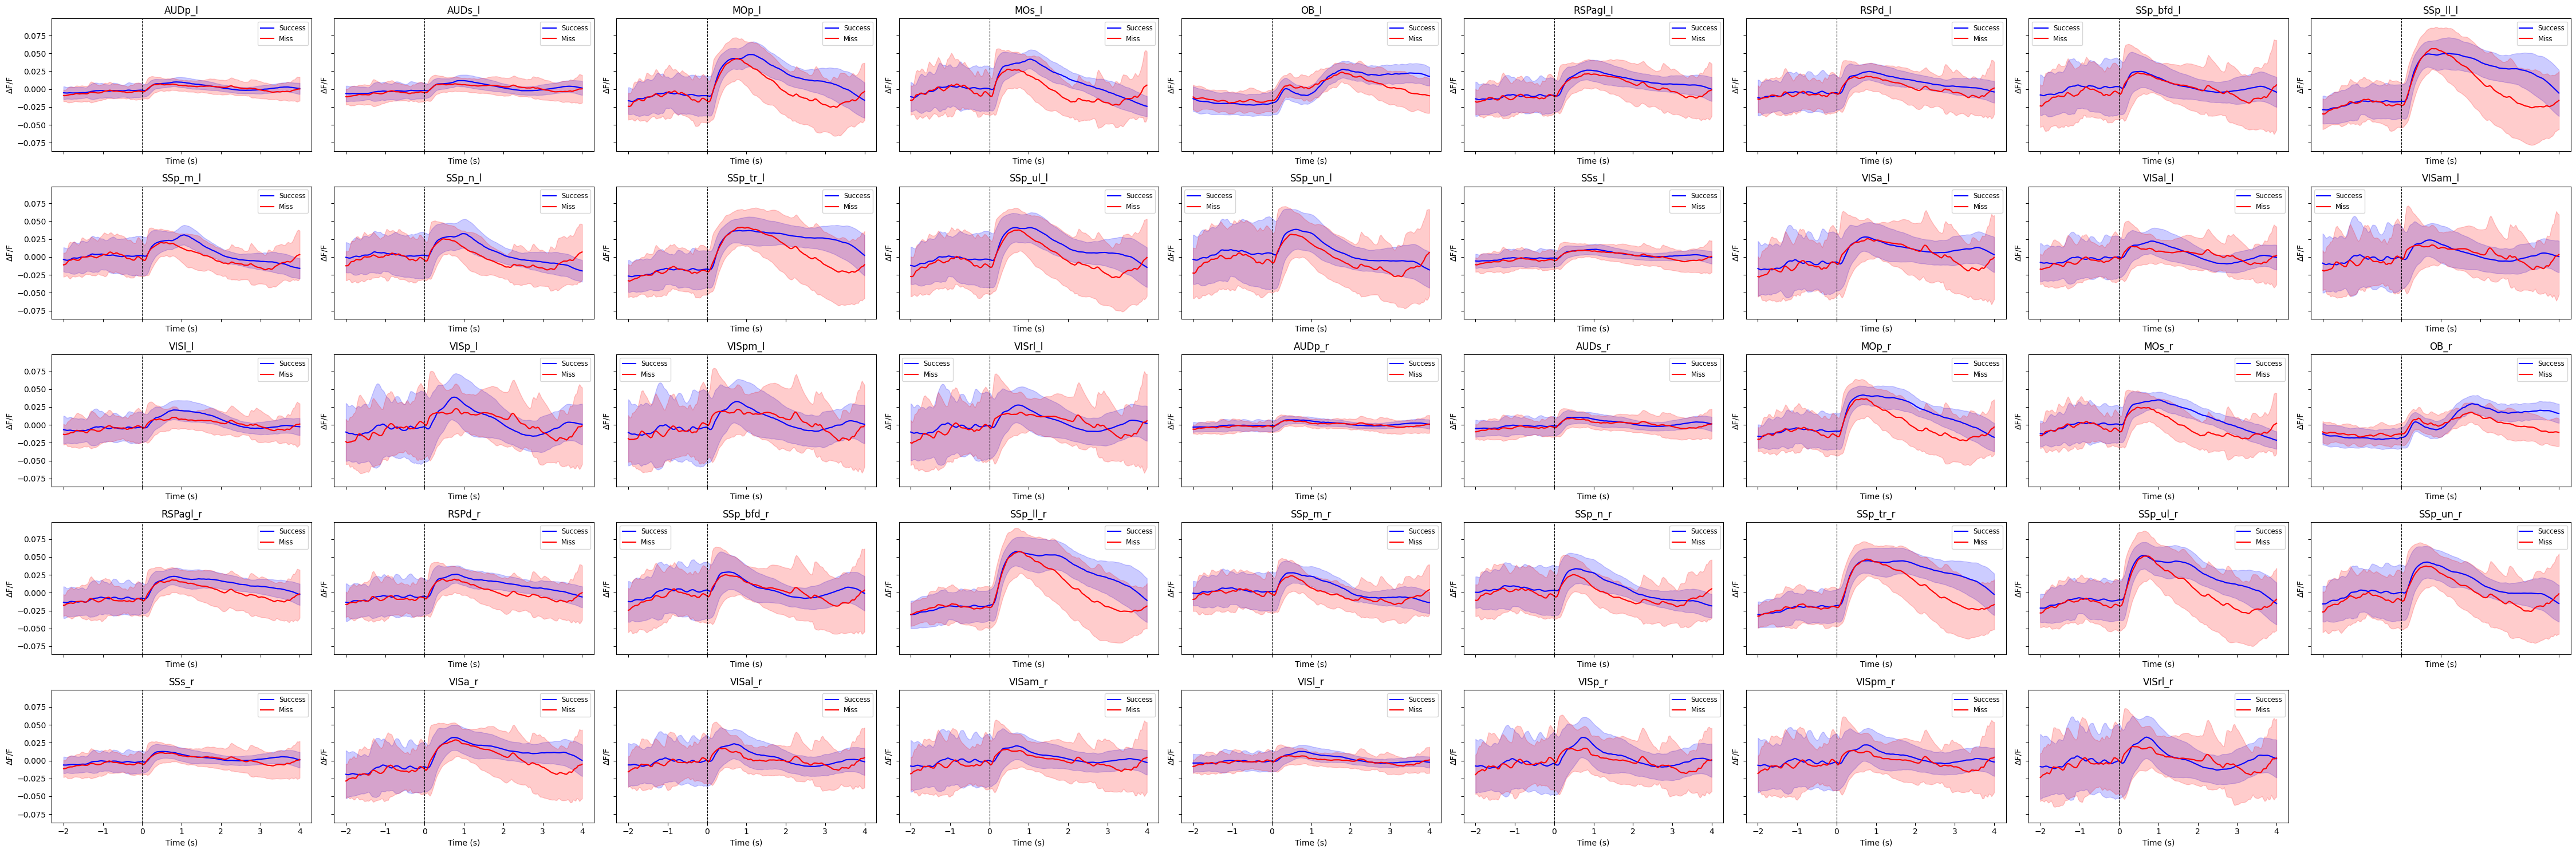

In [ ]:
#１個体の音への反応の違い
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

# dataroot = Path('/content/drive/MyDrive/braidyn-bc/data')
# testfile = dataroot / "VG1GC-105" / "VG1GC-105_2024-02-02_task-day8.nwb"
session = nwbx.read_nwb('/content/drive/MyDrive/braidyn-bc/data/VG1GC-51/VG1GC-51_2023-06-26_task-day8.nwb')

# === パラメータ ===
fs = 30
pre_time  = 2.0  # 開始前2秒
post_time = 4.0  # 終了後4秒
pre_samples  = int(pre_time * fs)
post_samples = int(post_time * fs)
window_len = pre_samples + post_samples + 1
time_axis = (np.arange(window_len) - pre_samples) / fs

# === データ取得 ===
all_rois = session.imaging.data
trial_df = session.trials.data
imaging_t = all_rois.index.to_numpy()

# === 成功/失敗で分けた試行ごとのデータ保存用辞書 ===
roi_trials_success = {roi: [] for roi in all_rois.columns}
roi_trials_fail    = {roi: [] for roi in all_rois.columns}

for idx, trial_start in enumerate(trial_df['start_time']):
    outcome = trial_df['trial_outcome'].iloc[idx]
    idx0 = np.searchsorted(imaging_t, trial_start)
    start_idx = idx0 - pre_samples
    end_idx   = idx0 + post_samples
    if start_idx < 0 or end_idx >= len(imaging_t):
        continue
    window = all_rois.iloc[start_idx:end_idx+1]
    for roi in all_rois.columns:
        if outcome == 'success' :
            roi_trials_success[roi].append(window[roi].values)
        elif outcome == 'miss' :
            roi_trials_fail[roi].append(window[roi].values)

# === 平均・標準偏差を計算 ===
roi_mean_succ, roi_std_succ = {}, {}
roi_mean_fail, roi_std_fail = {}, {}

for roi in all_rois.columns:
    # 成功
    if roi_trials_success[roi]:
        arr = np.stack(roi_trials_success[roi])
        roi_mean_succ[roi] = np.nanmean(arr, axis=0)
        roi_std_succ[roi]  = np.nanstd(arr, axis=0)
    # 失敗
    if roi_trials_fail[roi]:
        arr = np.stack(roi_trials_fail[roi])
        roi_mean_fail[roi] = np.nanmean(arr, axis=0)
        roi_std_fail[roi]  = np.nanstd(arr, axis=0)

# === プロット ===
n_rois = len(all_rois.columns)
n_cols = 9
n_rows = ceil(n_rois / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3), sharex=True, sharey=True)
axes = axes.flatten()

for ax, roi in zip(axes, all_rois.columns):
    has_data = False
    if roi in roi_mean_succ:
        m, s = roi_mean_succ[roi], roi_std_succ[roi]
        ax.plot(time_axis, m, label='Success', color='blue')
        ax.fill_between(time_axis, m - s, m + s, alpha=0.2, color='blue')
        has_data = True
    if roi in roi_mean_fail:
        m, s = roi_mean_fail[roi], roi_std_fail[roi]
        ax.plot(time_axis, m, label='Miss', color='red')
        ax.fill_between(time_axis, m - s, m + s, alpha=0.2, color='red')
        has_data = True
    if has_data:
        ax.axvline(0, color='k', linestyle='--', linewidth=0.8)
        ax.set_title(roi)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('ΔF/F')
        ax.legend(fontsize='small')
    else:
        ax.axis('off')  # データが全く無ければ非表示

for ax in axes[n_rois:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
1it [00:39, 39.79s/it]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
2it [01:07, 32.86s/it]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
3it [01:34, 30.08s/it]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because versio

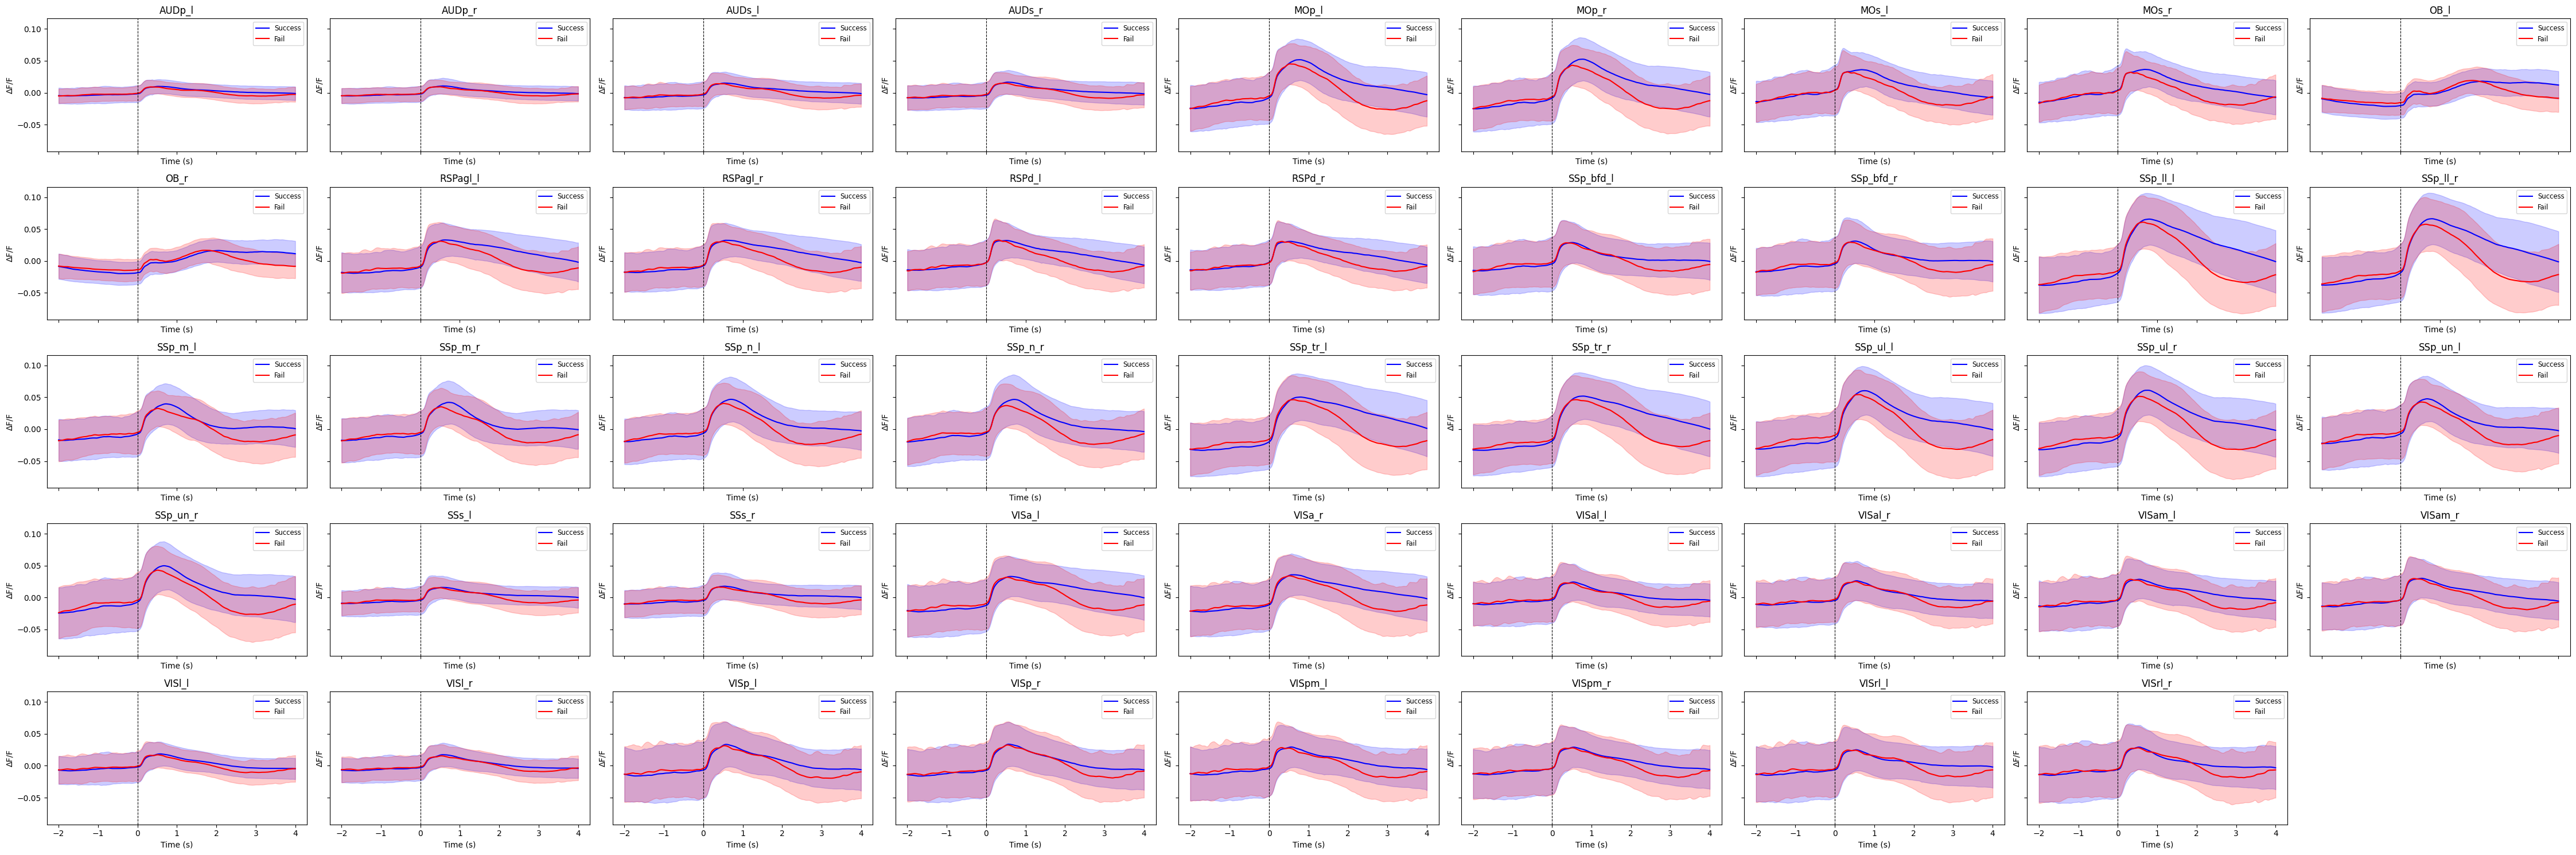

In [ ]:
#全個体の音への反応の違い
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from pathlib import Path
from tqdm import tqdm

# === パラメータ ===
fs = 30
pre_time = 2.0
post_time = 4.0
pre_samples = int(pre_time * fs)
post_samples = int(post_time * fs)
window_len = pre_samples + post_samples + 1
time_axis = (np.arange(window_len) - pre_samples) / fs

# === 入力ルートパス ===
root = Path("/content/drive/MyDrive/braidyn-bc/data")

# === ROI単位の全セッションデータ ===
roi_trials_success_all = {}
roi_trials_fail_all = {}

# === ファイルを再帰的に検索し、処理 ===
for file in tqdm(root.rglob("*task-day8.nwb")):
    try:
        session = nwbx.read_nwb(file)
        all_rois = session.imaging.data
        trial_df = session.trials.data
        imaging_t = all_rois.index.to_numpy()

        for idx, row in trial_df.iterrows():
            outcome = row["trial_outcome"]
            trial_start = row["start_time"]
            idx0 = np.searchsorted(imaging_t, trial_start)
            start_idx = idx0 - pre_samples
            end_idx = idx0 + post_samples
            if start_idx < 0 or end_idx >= len(imaging_t):
                continue
            window = all_rois.iloc[start_idx:end_idx+1]
            for roi in all_rois.columns:
                if outcome == "success":
                    roi_trials_success_all.setdefault(roi, []).append(window[roi].values)
                elif outcome == "miss":
                    roi_trials_fail_all.setdefault(roi, []).append(window[roi].values)

    except Exception as e:
        print(f"スキップ: {file.name} ({e})")

# === 各ROIについて平均・標準偏差を計算 ===
roi_mean_succ, roi_std_succ = {}, {}
roi_mean_fail, roi_std_fail = {}, {}

all_rois_set = set(roi_trials_success_all.keys()).union(roi_trials_fail_all.keys())

for roi in all_rois_set:
    if roi in roi_trials_success_all:
        arr = np.stack(roi_trials_success_all[roi])
        roi_mean_succ[roi] = np.nanmean(arr, axis=0)
        roi_std_succ[roi]  = np.nanstd(arr, axis=0)
    if roi in roi_trials_fail_all:
        arr = np.stack(roi_trials_fail_all[roi])
        roi_mean_fail[roi] = np.nanmean(arr, axis=0)
        roi_std_fail[roi]  = np.nanstd(arr, axis=0)

# === プロット ===
n_rois = len(all_rois_set)
n_cols = 9
n_rows = ceil(n_rois / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3), sharex=True, sharey=True)
axes = axes.flatten()

for ax, roi in zip(axes, sorted(all_rois_set)):
    has_data = False
    if roi in roi_mean_succ:
        m, s = roi_mean_succ[roi], roi_std_succ[roi]
        ax.plot(time_axis, m, label='Success', color='blue')
        ax.fill_between(time_axis, m - s, m + s, alpha=0.2, color='blue')
        has_data = True
    if roi in roi_mean_fail:
        m, s = roi_mean_fail[roi], roi_std_fail[roi]
        ax.plot(time_axis, m, label='Fail', color='red')
        ax.fill_between(time_axis, m - s, m + s, alpha=0.2, color='red')
        has_data = True
    if has_data:
        ax.axvline(0, color='k', linestyle='--', linewidth=0.8)
        ax.set_title(roi)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('ΔF/F')
        ax.legend(fontsize='small')
    else:
        ax.axis('off')

for ax in axes[n_rois:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


1it [00:03,  3.34s/it]


--- 処理中: VG1GC-53_2023-06-26_task-day8.nwb (マウスID: 053) ---


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
2it [01:06, 38.47s/it]

  ROI数: 44, 試行数: 211, Imaging長: 54000
  有効試行数: 211, スキップ試行数: 0

--- 処理中: VG1GC-51_2023-06-26_task-day8.nwb (マウスID: 051) ---


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
3it [01:53, 42.62s/it]

  ROI数: 44, 試行数: 203, Imaging長: 54000
  有効試行数: 203, スキップ試行数: 0

--- 処理中: VG1GC-61_2023-06-26_task-day8.nwb (マウスID: 061) ---


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


  ROI数: 44, 試行数: 147, Imaging長: 54000


6it [02:25, 21.37s/it]

  有効試行数: 147, スキップ試行数: 0

--- 処理中: VG1GC-66_2023-08-30_task-day8.nwb (マウスID: 066) ---


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
7it [03:01, 24.83s/it]

  ROI数: 44, 試行数: 153, Imaging長: 54000
  有効試行数: 152, スキップ試行数: 1

--- 処理中: VG1GC-63_2023-08-30_task-day8.nwb (マウスID: 063) ---


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
13it [03:32, 11.58s/it]

  ROI数: 44, 試行数: 52, Imaging長: 54000
  有効試行数: 52, スキップ試行数: 0

--- 処理中: VG1GC-48_2023-08-30_task-day8.nwb (マウスID: 048) ---


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


  ROI数: 44, 試行数: 182, Imaging長: 54000


14it [04:14, 15.83s/it]

  有効試行数: 182, スキップ試行数: 0

--- 処理中: VG1GC-105_2024-02-02_task-day8.nwb (マウスID: 105) ---


/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
15it [04:54, 19.82s/it]

  ROI数: 44, 試行数: 163, Imaging長: 54000
  有効試行数: 163, スキップ試行数: 0


25it [04:54, 11.78s/it]



=== 最終集計 ===
  Successに含まれるROI数: 44
  Failに含まれるROI数: 44


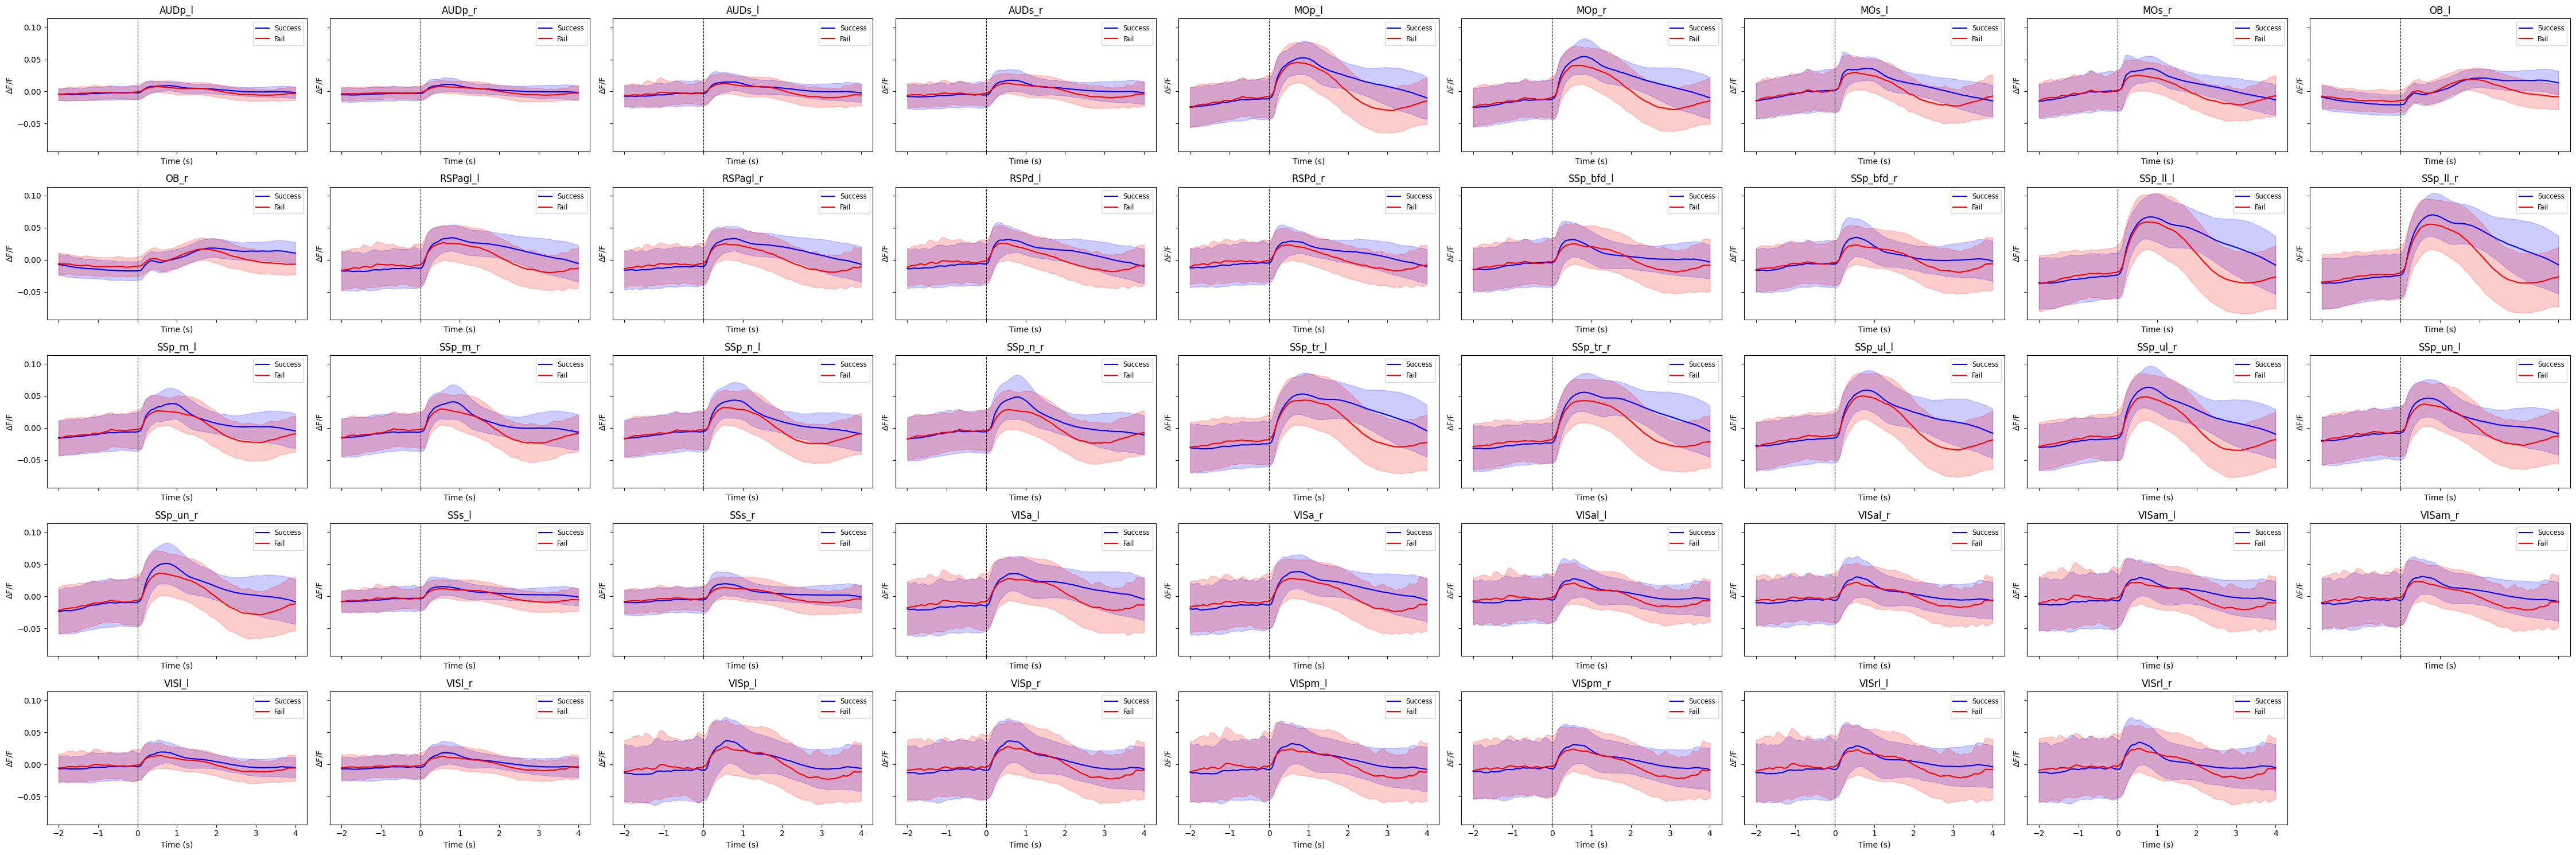

In [ ]:
#クラスタＡの音への反応の違い
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from pathlib import Path
from tqdm import tqdm

# === パラメータ ===
fs = 30
pre_time = 2.0
post_time = 4.0
pre_samples = int(pre_time * fs)
post_samples = int(post_time * fs)
window_len = pre_samples + post_samples + 1
time_axis = (np.arange(window_len) - pre_samples) / fs

# === 入力ルートパス ===
root = Path("/content/drive/MyDrive/braidyn-bc/data")

# === ROI単位の全セッションデータ ===
roi_trials_success_all = {}
roi_trials_fail_all = {}

# === 対象マウスのリスト ===
target_mouse_ids = {"051", "053", "105", "063", "061", "066", "048"}

# === ファイルを再帰的に検索し、処理 ===
for file in tqdm(root.rglob("*task-day8.nwb")):
    mouse_id = file.parts[-2].split("-")[-1].zfill(3)
    if mouse_id not in target_mouse_ids:
        continue

    try:
        print(f"\n--- 処理中: {file.name} (マウスID: {mouse_id}) ---")
        session = nwbx.read_nwb(file)
        all_rois = session.imaging.data
        trial_df = session.trials.data
        imaging_t = all_rois.index.to_numpy()

        print(f"  ROI数: {len(all_rois.columns)}, 試行数: {len(trial_df)}, Imaging長: {len(imaging_t)}")

        skipped_counter = 0
        used_counter = 0

        for idx, row in trial_df.iterrows():
            outcome = row["trial_outcome"]
            trial_start = row["start_time"]
            idx0 = np.searchsorted(imaging_t, trial_start)
            start_idx = idx0 - pre_samples
            end_idx = idx0 + post_samples
            if start_idx < 0 or end_idx >= len(imaging_t):
                skipped_counter += 1
                continue

            window = all_rois.iloc[start_idx:end_idx+1]
            for roi in all_rois.columns:
                if outcome == "success":
                    roi_trials_success_all.setdefault(roi, []).append(window[roi].values)
                elif outcome == "miss":
                    roi_trials_fail_all.setdefault(roi, []).append(window[roi].values)
            used_counter += 1

        print(f"  有効試行数: {used_counter}, スキップ試行数: {skipped_counter}")

    except Exception as e:
        print(f"  スキップ: {file.name} | エラー: {e}")

# === 成功/失敗ごとのROI登録状況 ===
print(f"\n=== 最終集計 ===")
print(f"  Successに含まれるROI数: {len(roi_trials_success_all)}")
print(f"  Failに含まれるROI数: {len(roi_trials_fail_all)}")

# === （以下はプロット部分のまま）===

# === 各ROIについて平均・標準偏差を計算 ===
roi_mean_succ, roi_std_succ = {}, {}
roi_mean_fail, roi_std_fail = {}, {}

all_rois_set = set(roi_trials_success_all.keys()).union(roi_trials_fail_all.keys())

for roi in all_rois_set:
    if roi in roi_trials_success_all:
        arr = np.stack(roi_trials_success_all[roi])
        roi_mean_succ[roi] = np.nanmean(arr, axis=0)
        roi_std_succ[roi]  = np.nanstd(arr, axis=0)
    if roi in roi_trials_fail_all:
        arr = np.stack(roi_trials_fail_all[roi])
        roi_mean_fail[roi] = np.nanmean(arr, axis=0)
        roi_std_fail[roi]  = np.nanstd(arr, axis=0)

# === プロット ===
n_rois = len(all_rois_set)
n_cols = 9
n_rows = ceil(n_rois / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3), sharex=True, sharey=True)
axes = axes.flatten()

for ax, roi in zip(axes, sorted(all_rois_set)):
    has_data = False
    if roi in roi_mean_succ:
        m, s = roi_mean_succ[roi], roi_std_succ[roi]
        ax.plot(time_axis, m, label='Success', color='blue')
        ax.fill_between(time_axis, m - s, m + s, alpha=0.2, color='blue')
        has_data = True
    if roi in roi_mean_fail:
        m, s = roi_mean_fail[roi], roi_std_fail[roi]
        ax.plot(time_axis, m, label='Fail', color='red')
        ax.fill_between(time_axis, m - s, m + s, alpha=0.2, color='red')
        has_data = True
    if has_data:
        ax.axvline(0, color='k', linestyle='--', linewidth=0.8)
        ax.set_title(roi)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('ΔF/F')
        ax.legend(fontsize='small')
    else:
        ax.axis('off')

for ax in axes[n_rois:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


1it [00:02,  2.78s/it]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
2it [01:19, 46.02s/it]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
3it [02:22, 54.12s/it]/usr/local/l

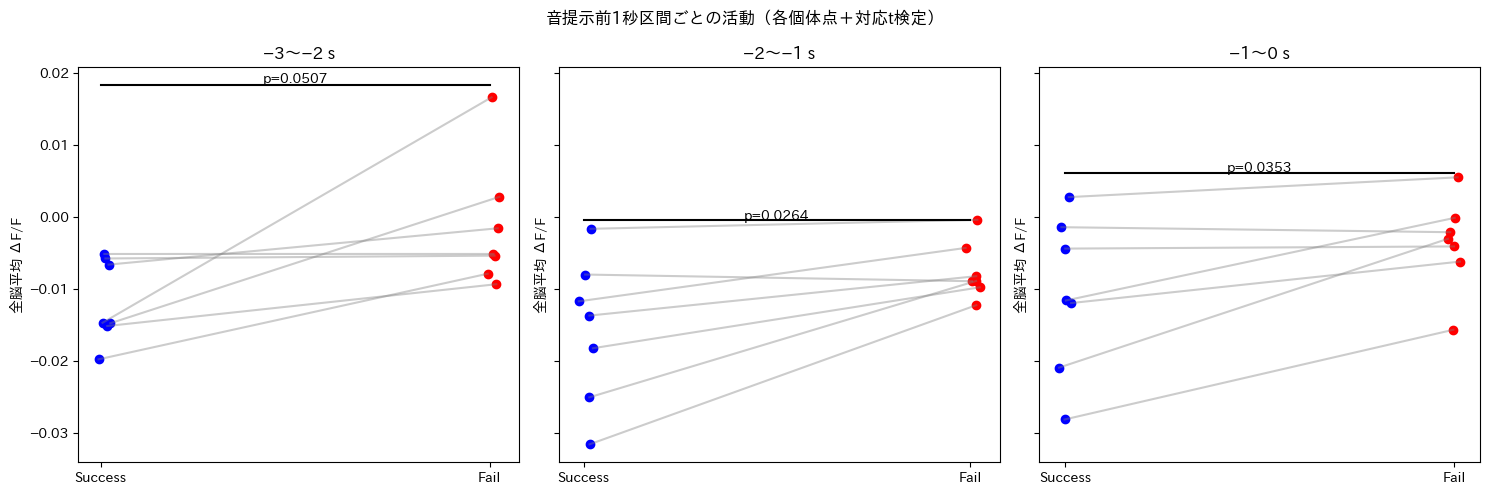

In [ ]:
#miss と failure の両方を「fail」に含めたver
import japanize_matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from scipy.stats import ttest_rel


# --------- パラメータ ---------
fs           = 30          # Hz
pre_time     = 3.0         # 解析したい前刺激時間（秒）
post_time    = 4.0         # 後刺激はそのまま
pre_samples  = int(pre_time * fs)
post_samples = int(post_time * fs)

root = Path("/content/drive/MyDrive/braidyn-bc/data")
mouse_ids = ["051","053","105","063","061","066","048"]  # 可視化対象

# 1 秒区間を 3 つに分割（index スライス）
seg_slices = {
    'seg1': slice(0,   30),   # −3〜−2 s
    'seg2': slice(30,  60),   # −2〜−1 s
    'seg3': slice(60,  90)    # −1〜 0 s
}
seg_names  = {'seg1':'−3〜−2 s', 'seg2':'−2〜−1 s', 'seg3':'−1〜0 s'}

# --------- データ収集 ---------
vals = {seg: {'success': {}, 'fail': {}} for seg in seg_slices}

for file in tqdm(root.rglob("*task-day8.nwb")):
    mid = file.parts[-2].split("-")[-1].zfill(3)
    if mid not in mouse_ids:
        continue
    session   = nwbx.read_nwb(file)
    rois      = session.imaging.data           # (time, ROI)
    trials    = session.trials.data
    imaging_t = rois.index.to_numpy()

    for _, row in trials.iterrows():
        # miss と failure の両方を「fail」に含める
        if row["trial_outcome"] not in ("success", "miss", "failure"):
            continue
        idx0 = np.searchsorted(imaging_t, row["start_time"])
        s, e = idx0 - pre_samples, idx0 + post_samples
        if s < 0 or e >= len(imaging_t):
            continue
        win = rois.iloc[s:e+1].mean(axis=1).values   # 全 ROI 平均

        for seg, sl in seg_slices.items():
            m = np.nanmean(win[sl])
            key = 'success' if row["trial_outcome"] == "success" else 'fail'
            vals[seg][key].setdefault(mid, []).append(m)

# --------- 可視化 ---------
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ax, seg in zip(axes, seg_slices):
    succ = []
    fail = []
    for mid in mouse_ids:
        s_list = vals[seg]['success'].get(mid, [])
        f_list = vals[seg]['fail'   ].get(mid, [])
        if s_list and f_list:
            succ.append(np.mean(s_list))
            fail.append(np.mean(f_list))
            jitter = (np.random.rand() - 0.5) * 0.06
            ax.scatter(0 + jitter, succ[-1], color='blue')
            ax.scatter(1 + jitter, fail[-1], color='red')
            ax.plot([0 + jitter, 1 + jitter], [succ[-1], fail[-1]], color='gray', alpha=0.4)

    # ---- 対応のある t 検定と p 値表示 ----
    if succ and fail:
        t, p = ttest_rel(succ, fail)
        ymax = max(max(succ), max(fail)) * 1.1
        ax.plot([0, 1], [ymax, ymax], color='k')
        ax.text(0.5, ymax * 1.02, f"p={p:.3g}", ha='center')

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Success", "Fail"])
    ax.set_title(seg_names[seg])
    ax.set_ylabel("全脳平均 ΔF/F")

fig.suptitle("音提示前1秒区間ごとの活動（各個体点＋対応t検定）")
plt.tight_layout()
plt.show()


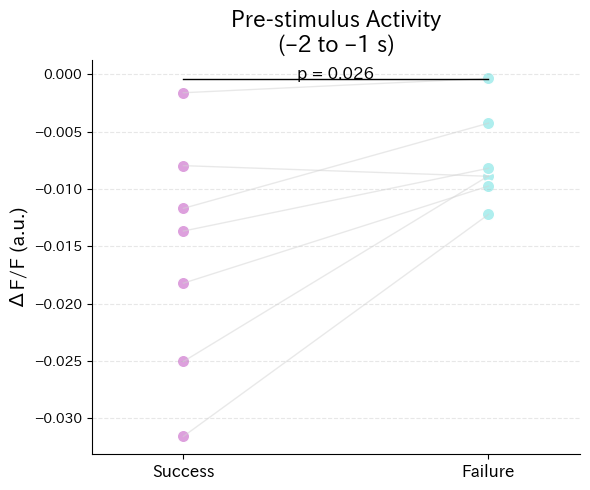

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel

# ---------- スタイリッシュな -2〜-1秒区間の可視化 ----------
seg = 'seg2'  # -2〜-1秒
# 個体ごとの平均を準備
succ_vals, fail_vals, pairs = [], [], []
for mid in mouse_ids:
    s = vals[seg]['success'].get(mid, [])
    f = vals[seg]['fail'   ].get(mid, [])
    if s and f:
        s_mean = np.mean(s)
        f_mean = np.mean(f)
        succ_vals.append(s_mean)
        fail_vals.append(f_mean)
        pairs.append((s_mean, f_mean))

# 対応のある t 検定
t_stat, p_val = ttest_rel(succ_vals, fail_vals)
# ↓ これをプロット直前に追加
pastel_success = 'plum'  # パステルブルー
pastel_failure = 'turquoise'  # パステルピーチ

# ---------- スタイリッシュな -2〜-1秒区間の可視化 ----------
fig, ax = plt.subplots(figsize=(6, 5))

# 個体間を結ぶ薄いグレーの線
for s_mean, f_mean in pairs:
    ax.plot([0, 1], [s_mean, f_mean], color='lightgray', alpha=0.5, linewidth=1)

# パステルカラーの点
ax.scatter([0]*len(succ_vals), succ_vals,
           color=pastel_success, edgecolors='white', s=80, label='Success')
ax.scatter([1]*len(fail_vals), fail_vals,
           color=pastel_failure, edgecolors='white', s=80, label='Failure')

# p 値のアノテーション
ymax = max(max(succ_vals), max(fail_vals)) * 1.1
ax.plot([0, 1], [ymax, ymax], color='black', linewidth=1)
ax.text(0.5, ymax * 1.02, f'p = {p_val:.3f}', ha='center', fontsize=12)

# 軸とタイトルを英語ラベルに
ax.set_title('Pre-stimulus Activity\n(–2 to –1 s)', fontsize=16, fontweight='bold')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Success', 'Failure'], fontsize=12)
ax.set_ylabel('ΔF/F (a.u.)', fontsize=14)
ax.set_xlim(-0.3, 1.3)

# 軸のスタイル
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


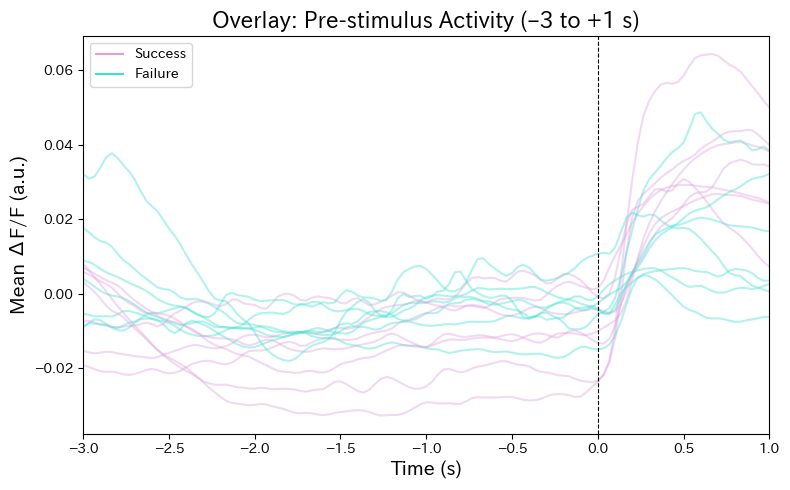

In [ ]:
#上のコードにfailure試行も加えて修正したもの

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

# ---------- パラメータ ----------
fs           = 30
pre_time     = 3.0
post_time    = 4.0
pre_samples  = int(pre_time  * fs)
post_samples = int(post_time * fs)
win_len      = pre_samples + post_samples + 1
time_axis    = (np.arange(win_len) - pre_samples) / fs  # -3 … +4秒

root       = Path("/content/drive/MyDrive/braidyn-bc/data")
mouse_ids  = ["051","053","105","063","061","066","048"]


# ---------- データ収集 ----------
succ_traces = {mid: [] for mid in mouse_ids}
fail_traces = {mid: [] for mid in mouse_ids}

for file in tqdm(root.rglob("*task-day8.nwb")):
    mid = file.parts[-2].split("-")[-1].zfill(3)
    if mid not in mouse_ids:
        continue
    session   = nwbx.read_nwb(file)
    rois      = session.imaging.data
    trials    = session.trials.data
    times     = rois.index.to_numpy()

    for _, row in trials.iterrows():
        if row["trial_outcome"] not in ("success", "miss", "failure"):
            continue
        idx0 = np.searchsorted(times, row["start_time"])
        s, e = idx0 - pre_samples, idx0 + post_samples
        if s < 0 or e >= len(times):
            continue
        trace = rois.iloc[s:e+1].mean(axis=1).values
        if row["trial_outcome"] == "success":
            succ_traces[mid].append(trace)
        else:
            fail_traces[mid].append(trace)

# ---------- 個体平均計算 ----------
mouse_plot_data = {}
for mid in mouse_ids:
    s_arr = np.stack(succ_traces[mid]) if succ_traces[mid] else None
    f_arr = np.stack(fail_traces[mid]) if fail_traces[mid] else None
    s_mean = np.nanmean(s_arr, axis=0) if s_arr is not None else None
    f_mean = np.nanmean(f_arr, axis=0) if f_arr is not None else None
    mouse_plot_data[mid] = (s_mean, f_mean)

# ---------- 色設定（パステル調） ----------
color_success = 'plum'
color_failure = 'turquoise'
# ---------- プロット（重ね合わせ, -3～+1秒） ----------
xmin, xmax = -3, 1
mask = (time_axis >= xmin) & (time_axis <= xmax)

plt.figure(figsize=(8, 5))
plt.plot([], [], color=color_success, label='Success')
plt.plot([], [], color=color_failure, label='Failure')

for mid in mouse_ids:
    s_mean, f_mean = mouse_plot_data[mid]
    if s_mean is not None:
        plt.plot(time_axis[mask], s_mean[mask],
                 color=color_success, alpha=0.4)
    if f_mean is not None:
        plt.plot(time_axis[mask], f_mean[mask],
                 color=color_failure, alpha=0.4)

plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlim(xmin, xmax)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Mean ΔF/F (a.u.)", fontsize=14)
plt.title("Overlay: Pre-stimulus Activity (–3 to +1 s)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


**↑failure vs success,missでレバー引き有無での活動の違いを見るのもいいかもしれない**

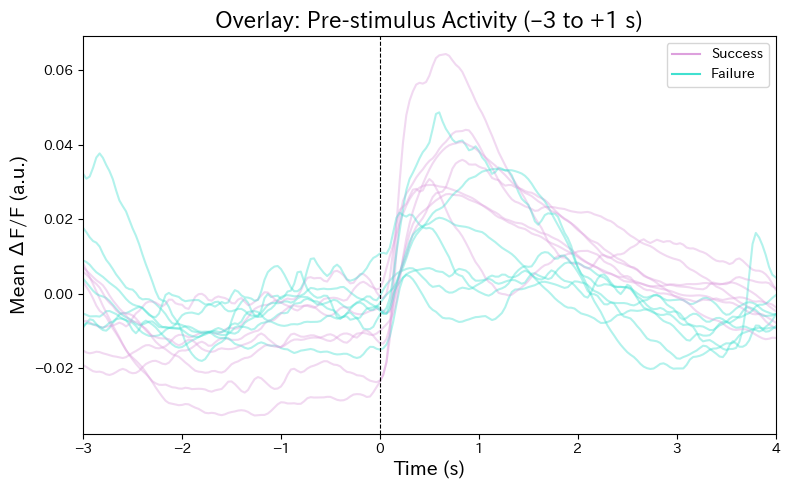

In [ ]:

# ---------- 個体平均計算 ----------
mouse_plot_data = {}
for mid in mouse_ids:
    s_arr = np.stack(succ_traces[mid]) if succ_traces[mid] else None
    f_arr = np.stack(fail_traces[mid]) if fail_traces[mid] else None
    s_mean = np.nanmean(s_arr, axis=0) if s_arr is not None else None
    f_mean = np.nanmean(f_arr, axis=0) if f_arr is not None else None
    mouse_plot_data[mid] = (s_mean, f_mean)

# ---------- 色設定（パステル調） ----------
color_success = 'plum'
color_failure = 'turquoise'
# ---------- プロット（重ね合わせ, -3～+1秒） ----------
xmin, xmax = -3, 4
mask = (time_axis >= xmin) & (time_axis <= xmax)

plt.figure(figsize=(8, 5))
plt.plot([], [], color=color_success, label='Success')
plt.plot([], [], color=color_failure, label='Failure')

for mid in mouse_ids:
    s_mean, f_mean = mouse_plot_data[mid]
    if s_mean is not None:
        plt.plot(time_axis[mask], s_mean[mask],
                 color=color_success, alpha=0.4)
    if f_mean is not None:
        plt.plot(time_axis[mask], f_mean[mask],
                 color=color_failure, alpha=0.4)

plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlim(xmin, xmax)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Mean ΔF/F (a.u.)", fontsize=14)
plt.title("Overlay: Pre-stimulus Activity (–3 to +1 s)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
2it [01:00, 30.29s/it]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
3it [01:57, 41.36s/it]/usr/local/lib/p

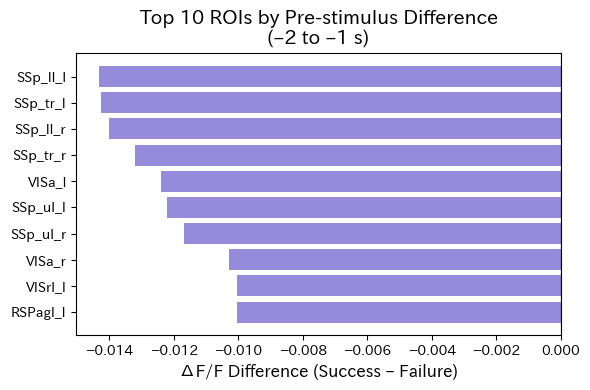

        ROI  mean_diff    t_stat     p_val
0  SSp_ll_l  -0.014322 -3.054596  0.022380
1  SSp_tr_l  -0.014252 -3.001672  0.023956
2  SSp_ll_r  -0.014023 -2.924679  0.026470
3  SSp_tr_r  -0.013197 -3.113534  0.020755
4    VISa_l  -0.012392 -3.158233  0.019609
5  SSp_ul_l  -0.012218 -2.511448  0.045813
6  SSp_ul_r  -0.011690 -2.523908  0.045049
7    VISa_r  -0.010288 -2.752022  0.033203
8   VISrl_l  -0.010051 -2.806791  0.030886
9  RSPagl_l  -0.010033 -3.214694  0.018259


In [ ]:
#FDRなしで、各脳領域の音の反応の有意差を確認（-2 ~ -1秒）。データ処理用として必要
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from scipy.stats import ttest_rel


# ---------- パラメータ ----------
fs           = 30
pre_time     = 3.0
post_time    = 4.0
pre_samples  = int(pre_time  * fs)
post_samples = int(post_time * fs)
win_len      = pre_samples + post_samples + 1
# −3…0…+4秒のうち −2～−1秒に対応するインデックス
seg2_slice   = slice(pre_samples - 2*fs, pre_samples - 1*fs)

root      = Path("/content/drive/MyDrive/braidyn-bc/data")
mouse_ids = ["051","053","105","063","061","066","048"]

# ---------- ROIごとのデータ収集 ----------
roi_vals = {}  # roi_vals[roi] = {'success': {mid: [means...]}, 'fail': {mid: [...]}}
for file in tqdm(root.rglob("*task-day8.nwb")):
    mid = file.parts[-2].split("-")[-1].zfill(3)
    if mid not in mouse_ids:
        continue

    session = nwbx.read_nwb(file)
    rois    = session.imaging.data       # DataFrame (time × ROI)
    trials  = session.trials.data
    times   = rois.index.to_numpy()

    for _, row in trials.iterrows():
        out = row["trial_outcome"]
        if out not in ("success","miss","failure"):
            continue
        idx0 = np.searchsorted(times, row["start_time"])
        s, e = idx0 - pre_samples, idx0 + post_samples
        if s<0 or e>=len(times):
            continue

        window = rois.iloc[s:e+1]          # shape (win_len × n_rois)
        for roi in rois.columns:
            trace = window[roi].values[seg2_slice].mean()
            key = 'success' if out=="success" else 'fail'
            roi_vals.setdefault(roi, {'success':{}, 'fail':{}}) \
                   [key].setdefault(mid, []).append(trace)

# ---------- ROIごとに t検定 & 効果量計算 ----------
results = []
for roi, grp in roi_vals.items():
    succ = []
    fail = []
    for mid in mouse_ids:
        if mid in grp['success'] and mid in grp['fail']:
            succ.append(np.mean(grp['success'][mid]))
            fail.append(np.mean(grp['fail'][mid]))
    if len(succ) > 1:
        t_stat, p_val = ttest_rel(succ, fail)
        diff = np.mean(succ) - np.mean(fail)
        results.append((roi, diff, t_stat, p_val))

# DataFrame にまとめて差の絶対値でソート
df = pd.DataFrame(results, columns=['ROI','mean_diff','t_stat','p_val'])
df['abs_diff'] = df['mean_diff'].abs()
df = df.sort_values('abs_diff', ascending=False).reset_index(drop=True)

# 上位 10 ROI をプロット
topn = 10
plt.figure(figsize=(6, topn*0.4))
bars = plt.barh(df['ROI'][:topn][::-1],
                df['mean_diff'][:topn][::-1],
                color='slateblue', alpha=0.7)
plt.axvline(0, color='k', linewidth=0.8)
plt.xlabel('ΔF/F Difference (Success – Failure)', fontsize=12)
plt.title(f'Top {topn} ROIs by Pre-stimulus Difference\n(–2 to –1 s)', fontsize=14)
plt.tight_layout()
plt.show()

# 結果テーブルを表示
print(df[['ROI','mean_diff','t_stat','p_val']].head(topn))


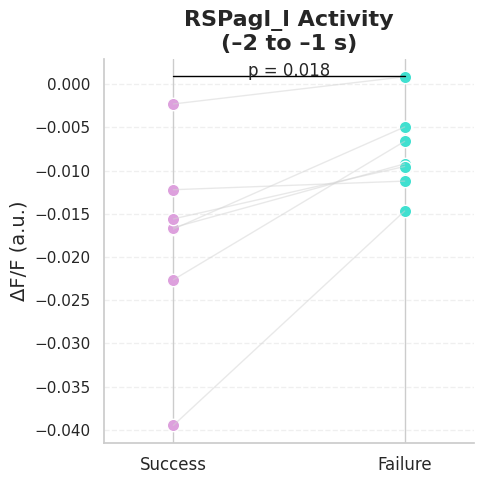

In [ ]:
#RSPの活動の有意差を計算

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_rel

roi_name = "RSPagl_l"
succ_vals, fail_vals, pairs = [], [], []

for mid in mouse_ids:
    s_list = roi_vals[roi_name]['success'].get(mid, [])
    f_list = roi_vals[roi_name]['fail'].get(mid, [])
    if s_list and f_list:
        s_mean = np.mean(s_list)
        f_mean = np.mean(f_list)
        succ_vals.append(s_mean)
        fail_vals.append(f_mean)
        pairs.append((s_mean, f_mean))

# 対応のある t検定
t_stat, p_val = ttest_rel(succ_vals, fail_vals)

# プロット
fig, ax = plt.subplots(figsize=(5, 5))
for s_mean, f_mean in pairs:
    ax.plot([0, 1], [s_mean, f_mean], color='lightgray', alpha=0.5, linewidth=1)

ax.scatter([0]*len(succ_vals), succ_vals,
           color='plum', edgecolors='white', s=80, label='Success')
ax.scatter([1]*len(fail_vals), fail_vals,
           color='turquoise', edgecolors='white', s=80, label='Failure')

# p値表示
ymax = max(max(succ_vals), max(fail_vals)) * 1.1
ax.plot([0, 1], [ymax, ymax], color='black', linewidth=1)
ax.text(0.5, ymax * 1.02, f'p = {p_val:.3f}', ha='center', fontsize=12)

ax.set_title(f'RSPagl_l Activity\n(–2 to –1 s)', fontsize=16, fontweight='bold')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Success', 'Failure'], fontsize=12)
ax.set_ylabel('ΔF/F (a.u.)', fontsize=14)
ax.set_xlim(-0.3, 1.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
2it [01:04, 32.03s/it]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
3it [02:43, 60.20s/it]/usr/local/lib/p

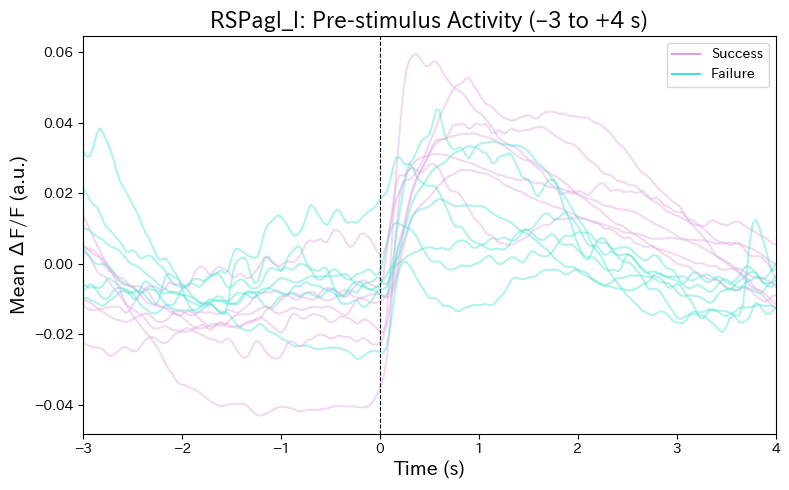

In [ ]:
# 各マウスの試行ごと平均波形を格納
succ_traces, fail_traces = {}, {}
for mid in mouse_ids:
    succ_traces[mid] = []
    fail_traces[mid] = []

# 試行ごとの波形データを再収集
for file in tqdm(root.rglob("*task-day8.nwb")):
    mid = file.parts[-2].split("-")[-1].zfill(3)
    if mid not in mouse_ids:
        continue

    session = nwbx.read_nwb(file)
    rois    = session.imaging.data
    trials  = session.trials.data
    times   = rois.index.to_numpy()

    for _, row in trials.iterrows():
        out = row["trial_outcome"]
        if out not in ("success", "miss", "failure"):
            continue
        idx0 = np.searchsorted(times, row["start_time"])
        s, e = idx0 - pre_samples, idx0 + post_samples
        if s < 0 or e >= len(times):
            continue

        window = rois.iloc[s:e+1]
        trace = window["RSPagl_l"].values
        if out == "success":
            succ_traces[mid].append(trace)
        else:
            fail_traces[mid].append(trace)

# 個体平均計算
mouse_plot_data = {}
for mid in mouse_ids:
    s_arr = np.stack(succ_traces[mid]) if succ_traces[mid] else None
    f_arr = np.stack(fail_traces[mid]) if fail_traces[mid] else None
    s_mean = np.nanmean(s_arr, axis=0) if s_arr is not None else None
    f_mean = np.nanmean(f_arr, axis=0) if f_arr is not None else None
    mouse_plot_data[mid] = (s_mean, f_mean)

# 描画
time_axis = (np.arange(win_len) - pre_samples) / fs
xmin, xmax = -3, 4
mask = (time_axis >= xmin) & (time_axis <= xmax)

plt.figure(figsize=(8, 5))
plt.plot([], [], color='plum', label='Success')
plt.plot([], [], color='turquoise', label='Failure')

for mid in mouse_ids:
    s_mean, f_mean = mouse_plot_data[mid]
    if s_mean is not None:
        plt.plot(time_axis[mask], s_mean[mask], color='plum', alpha=0.4)
    if f_mean is not None:
        plt.plot(time_axis[mask], f_mean[mask], color='turquoise', alpha=0.4)

plt.axvline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlim(xmin, xmax)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Mean ΔF/F (a.u.)", fontsize=14)
plt.title("RSPagl_l: Pre-stimulus Activity (–3 to +4 s)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#FDR補正を用いて44領域に有意差があるか確認（なかった
import numpy as np, pandas as pd

rows = []  # [(roi, mouse_id, mean_success, mean_fail), …]
for roi, cond_dict in roi_vals.items():
    for mid in set(cond_dict['success']) & set(cond_dict['fail']):
        rows.append([roi,
                     mid,
                     np.mean(cond_dict['success'][mid]),
                     np.mean(cond_dict['fail'   ][mid])])

df_mouse = pd.DataFrame(rows,                 # ROI × Mouse の 2 条件テーブル
                        columns=['ROI','mouse','succ','fail'])
from scipy.stats import ttest_rel

stats = []
for roi, sub in df_mouse.groupby('ROI'):
    t, p = ttest_rel(sub['succ'], sub['fail'])
    diff  = sub['succ'] - sub['fail']
    cohen_d = diff.mean() / diff.std(ddof=1)   # paired-d
    stats.append([roi, t, p, cohen_d, diff.mean()])

stats_df = pd.DataFrame(stats,
                        columns=['ROI','t','p_unc','cohen_d','mean_diff'])

from statsmodels.stats.multitest import multipletests
rej, p_fdr, _, _ = multipletests(stats_df['p_unc'],
                                 alpha=0.05,
                                 method='fdr_bh')
stats_df['p_fdr'] = p_fdr
stats_df['sig']   = rej          # True = q<0.05 で有意


In [ ]:
stats_df.head(5)

ROI         t     p_unc   cohen_d  mean_diff     p_fdr    sig
0  AUDp_l -3.406012  0.014389 -1.287352  -0.002327  0.066889  False
1  AUDp_r -2.251144  0.065338 -0.850853  -0.003187  0.073715  False
2  AUDs_l -3.847801  0.008482 -1.454332  -0.004149  0.066889  False
3  AUDs_r -2.272625  0.063439 -0.858972  -0.005490  0.073455  False
4   MOp_l -2.781135  0.031949 -1.051170  -0.008740  0.066889  False

In [ ]:
#有意差なかったから領域を12個にして確認

def classify_roi(roi_name):
    if roi_name.startswith("AUD"):
        group = "AUD"
    elif roi_name.startswith("MO"):
        group = "MO"
    elif roi_name.startswith("OB"):
        group = "OB"
    elif roi_name.startswith("RSP"):
        group = "RSP"
    elif roi_name.startswith("SS"):
        group = "SS"
    elif roi_name.startswith("VIS") or roi_name.startswith("VI"):
        group = "VIS"
    else:
        group = "OTHER"

    if roi_name.endswith("_l"):
        side = "l"
    elif roi_name.endswith("_r"):
        side = "r"
    else:
        side = "unk"

    return f"{group}_{side}"
df_mouse['group'] = df_mouse['ROI'].apply(classify_roi)
group_vals = []
for group, subdf in df_mouse.groupby('group'):
    for mid in subdf['mouse'].unique():
        msub = subdf[subdf['mouse'] == mid]
        group_vals.append([
            group, mid,
            msub['succ'].mean(),
            msub['fail'].mean()
        ])

df_group = pd.DataFrame(group_vals, columns=['group','mouse','succ','fail'])

# t検定
from scipy.stats import ttest_rel

group_stats = []
for group, gsub in df_group.groupby('group'):
    t, p = ttest_rel(gsub['succ'], gsub['fail'])
    diff  = gsub['succ'] - gsub['fail']
    d = diff.mean() / diff.std(ddof=1)
    group_stats.append([group, t, p, d])

df_stat12 = pd.DataFrame(group_stats, columns=['group','t','p','cohen_d'])


In [ ]:
df_stat12

group         t         p   cohen_d
0   AUD_l -3.741206  0.009609 -1.414043
1   AUD_r -2.270629  0.063613 -0.858217
2    MO_l -2.713480  0.034944 -1.025599
3    MO_r -2.949125  0.025642 -1.114665
4    OB_l -3.831190  0.008647 -1.448054
5    OB_r -3.495185  0.012902 -1.321056
6   RSP_l -2.863169  0.028682 -1.082176
7   RSP_r -2.443151  0.050256 -0.923424
8    SS_l -2.734353  0.033989 -1.033488
9    SS_r -2.626735  0.039231 -0.992812
10  VIS_l -3.051457  0.022470 -1.153342
11  VIS_r -2.476536  0.048030 -0.936042

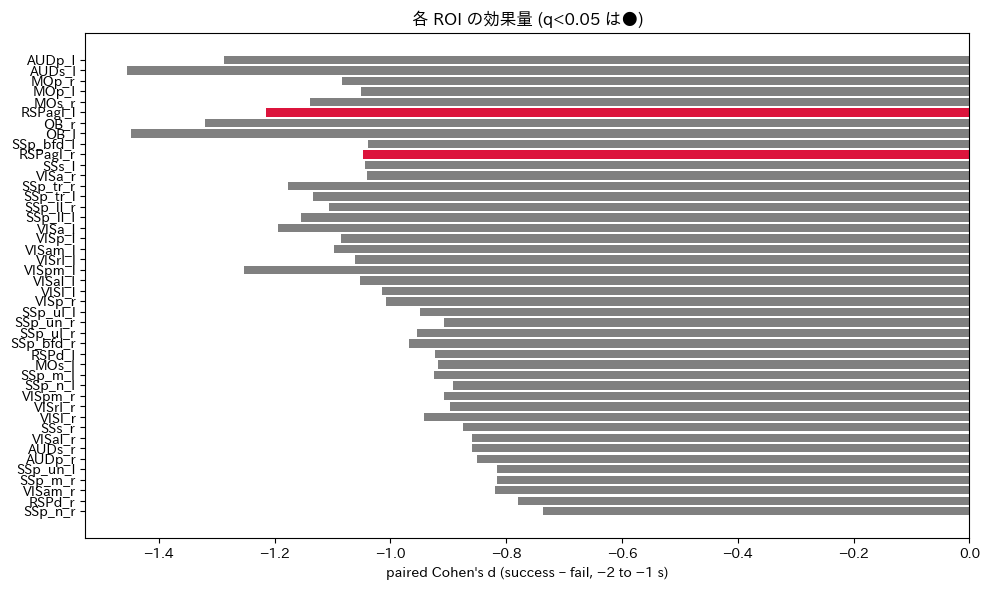

In [ ]:
import numpy as np, pandas as pd
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection

# ---------- 1) trial→mouse 平均 ----------
roi_mouse = []
for roi, cond in roi_vals.items():
    for mid in mouse_ids:
        if mid in cond['success'] and mid in cond['fail']:
            roi_mouse.append({
                'roi': roi,
                'mid': mid,
                'succ_mean': np.mean(cond['success'][mid]),
                'fail_mean': np.mean(cond['fail'][mid]),
            })
df = pd.DataFrame(roi_mouse)

# ---------- 2) t 検定＋効果量 ----------
rows = []
for roi, sub in df.groupby('roi'):
    succ = sub['succ_mean'].to_numpy()
    fail = sub['fail_mean'].to_numpy()
    if len(succ) < 3:             # マウス数が少なすぎる ROI はスキップ
        continue
    t, p = ttest_rel(succ, fail)
    diff = succ - fail
    d = diff.mean() / diff.std(ddof=1)     # paired Cohen's d
    rows.append((roi, p, d, len(succ)))
res = pd.DataFrame(rows, columns=['roi', 'p', 'd', 'n_mouse'])

# ---------- 3) FDR 補正 ----------
res['q'] = fdrcorrection(res['p'])[1]

# ---------- 4) 並び替え ----------
res = res.sort_values('q')

# ---------- 5) 可視化 ----------
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
bars = plt.barh(res['roi'], res['d'], color=[
    'crimson' if r in ('RSPagl_r','RSPagl_l') else 'grey'
    for r in res['roi']])
plt.axvline(0, color='k', lw=0.7)
plt.gca().invert_yaxis()
plt.xlabel("paired Cohen's d (success – fail, −2 to −1 s)")
plt.title("各 ROI の効果量 (q<0.05 は●)")
for bar, q in zip(bars, res['q']):
    if q < 0.05:
        plt.plot(bar.get_width(), bar.get_y()+bar.get_height()/2, 'k.')
plt.tight_layout()
plt.show()


In [ ]:
# 各マウスで全脳 Δ を計算
roi_mouse = []
for roi, cond in roi_vals.items():
    for mid in mouse_ids:
        succ_vals = cond['success'].get(mid)
        fail_vals = cond['fail'].get(mid)
        if succ_vals is not None and fail_vals is not None:
            roi_mouse.append({
                'roi': roi,
                'mid': mid,
                'succ_mean': np.mean(succ_vals),
                'fail_mean': np.mean(fail_vals),
            })
df = pd.DataFrame(roi_mouse)

df['whole_delta'] = df.groupby('mid').apply(
    lambda g: (g['succ_mean'] - g['fail_mean']).mean()
).reset_index(level=0, drop=True)

# ROI Δ と全脳 Δ の相関
corrs = df.groupby('roi').apply(
    lambda g: np.corrcoef(g['succ_mean'] - g['fail_mean'],
                          g['whole_delta'])[0,1]
).rename('corr_with_global').to_frame()


<ipython-input-45-0bf113fb8797>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['whole_delta'] = df.groupby('mid').apply(
<ipython-input-45-0bf113fb8797>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corrs = df.groupby('roi').apply(


0it [00:00, ?it/s]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
2it [01:02, 31.35s/it]/usr/local/lib/python3.11/dist-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
3it [01:55, 40.17s/it]/usr/local/lib/p

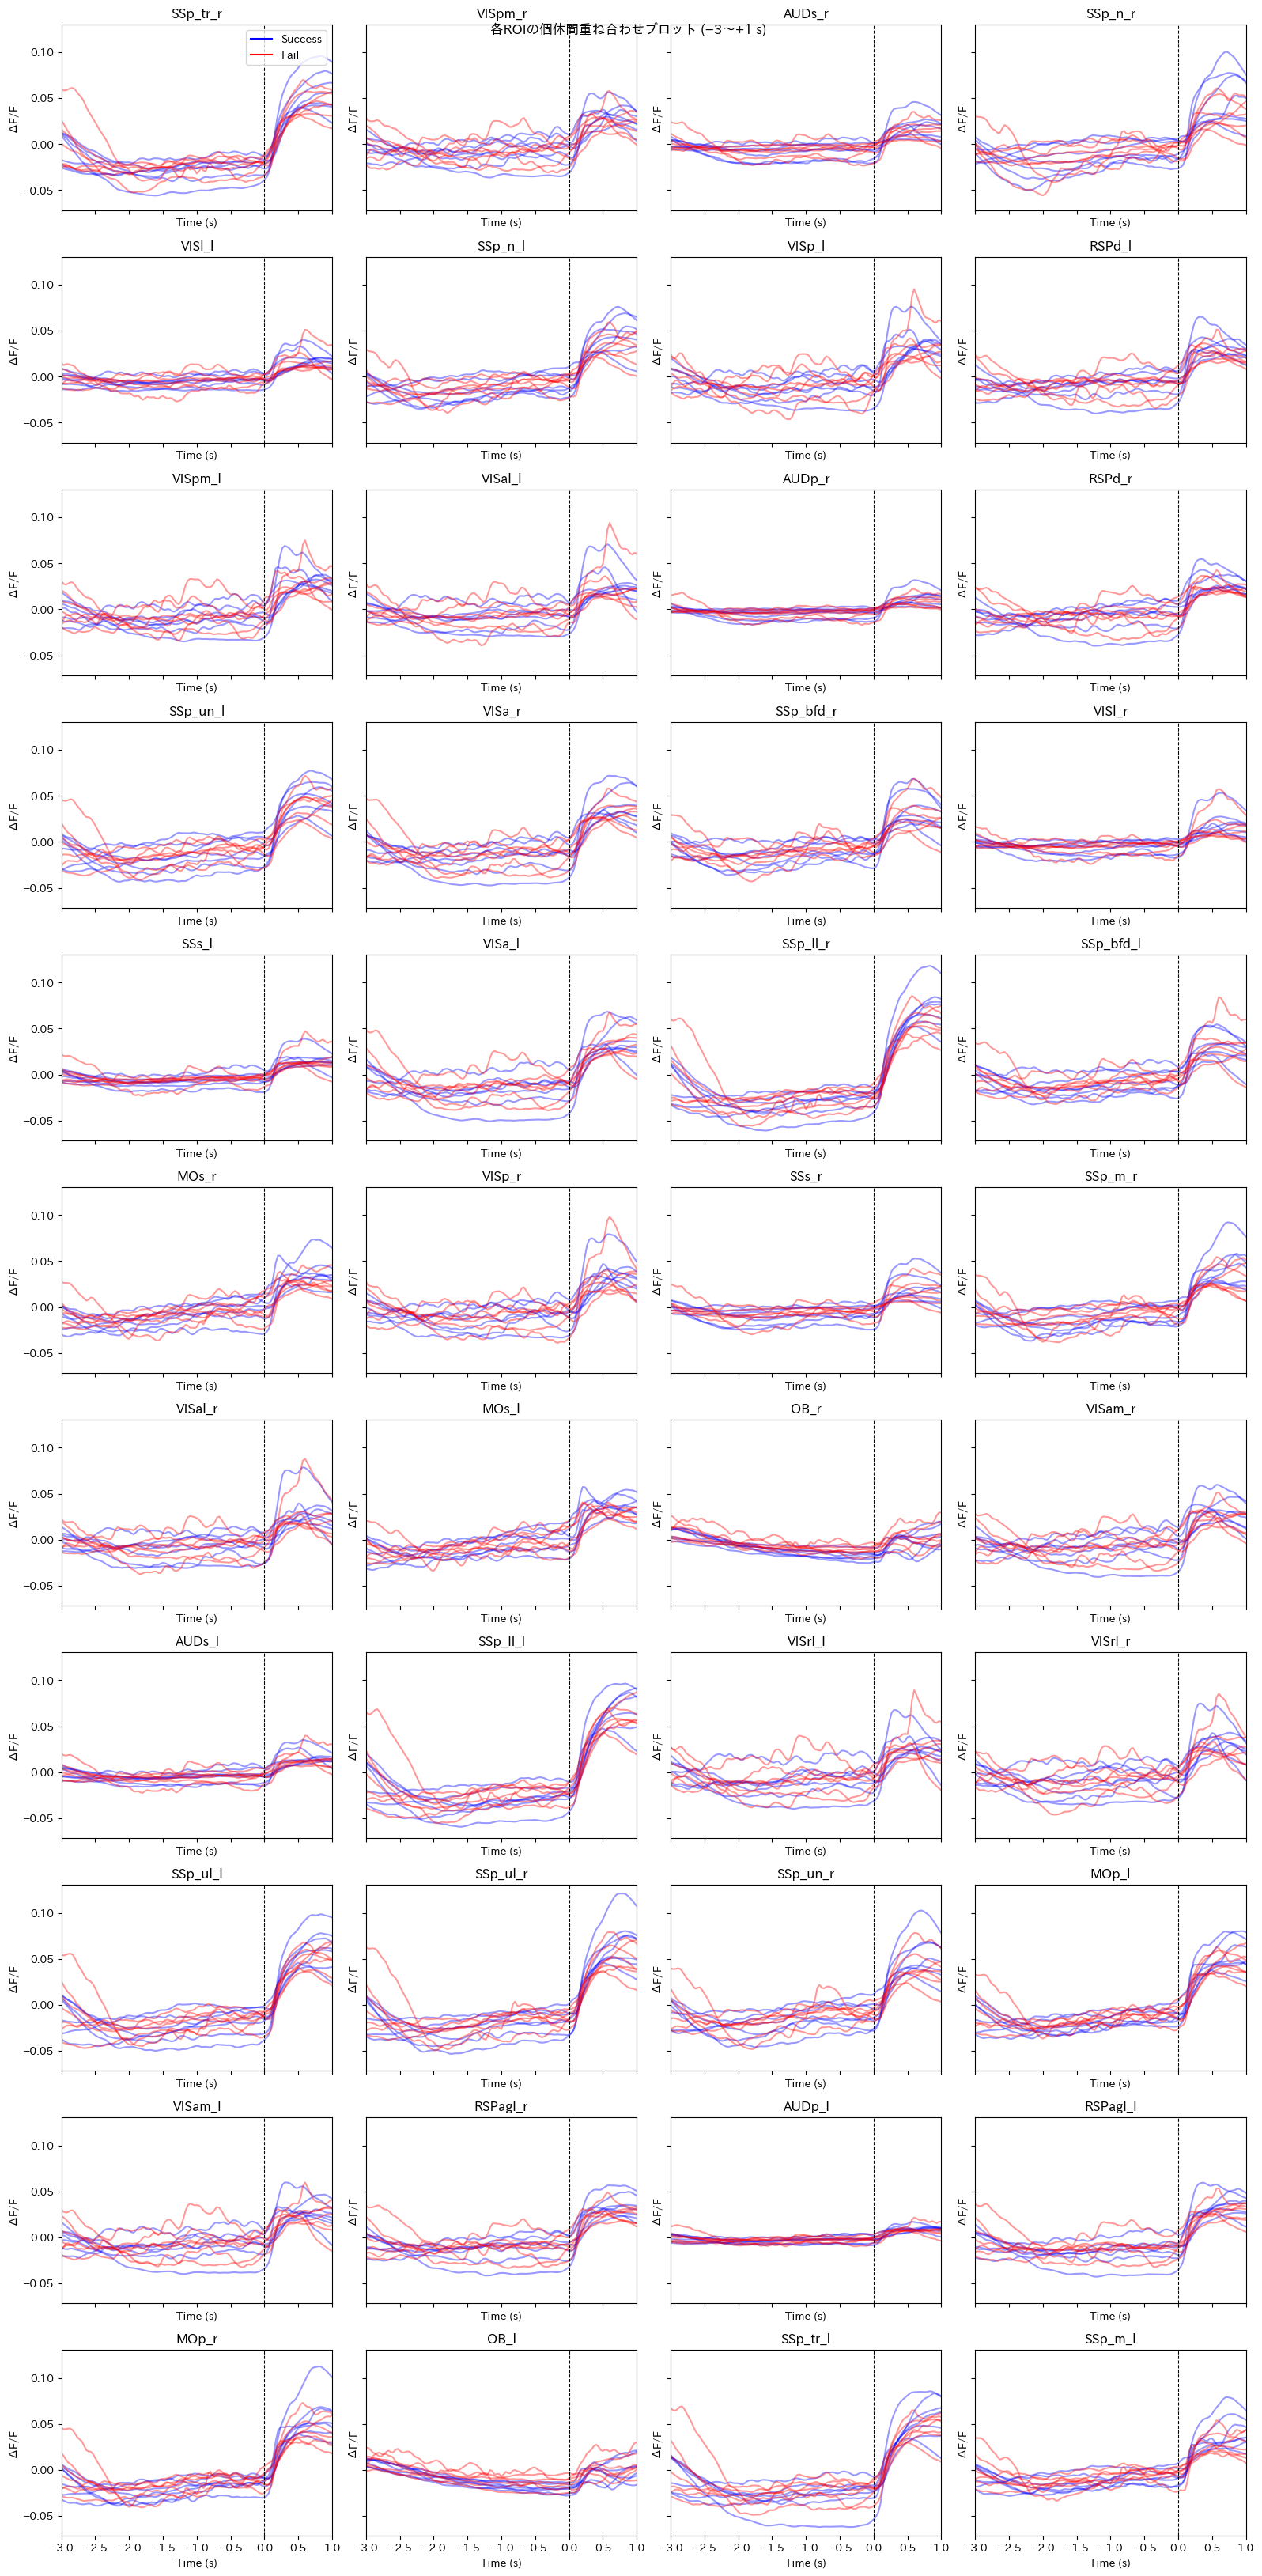

In [ ]:
#各脳領域にたいして、個体間の違いを表示している

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm


# ---------- 解析パラメータ ----------
fs           = 30         # imaging frame rate [Hz]
pre_time     = 3.0        # 試行開始前に戻る時間 [s]
post_time    = 4.0        # 試行開始後に追跡する時間 [s]
pre_samples  = int(pre_time  * fs)
post_samples = int(post_time * fs)
win_len      = pre_samples + post_samples + 1
time_axis    = (np.arange(win_len) - pre_samples) / fs   # −3 … 0 … +4 s

root      = Path("/content/drive/MyDrive/braidyn-bc/data")
mouse_ids = ["051","053","105","063","061","066","048"]

# ---------- ROIごとの試行トレースを収集 ----------
succ_roi = {}  # succ_roi[roi][mid] = list of (time,) arrays
fail_roi = {}

for file in tqdm(root.rglob("*task-day8.nwb")):
    mid = file.parts[-2].split("-")[-1].zfill(3)
    if mid not in mouse_ids:
        continue
    session   = nwbx.read_nwb(file)
    rois      = session.imaging.data      # DataFrame: index=time, columns=ROIs
    trials    = session.trials.data
    imaging_t = rois.index.to_numpy()

    for _, row in trials.iterrows():
        if row["trial_outcome"] not in ("success","miss"):
            continue
        idx0 = np.searchsorted(imaging_t, row["start_time"])
        s, e = idx0 - pre_samples, idx0 + post_samples
        if s < 0 or e >= len(imaging_t):
            continue

        window = rois.iloc[s:e+1]            # (win_len, n_rois)
        for roi in rois.columns:
            trace = window[roi].values        # (win_len,)
            if row["trial_outcome"] == "success":
                succ_roi.setdefault(roi, {}).setdefault(mid, []).append(trace)
            else:
                fail_roi.setdefault(roi, {}).setdefault(mid, []).append(trace)

# ---------- ROIごとにマウス平均を計算 ----------
roi_plot_data = {}  # roi_plot_data[roi] = (succ_means, fail_means)
for roi in succ_roi.keys() | fail_roi.keys():
    succ_means = {}
    fail_means = {}
    for mid in mouse_ids:
        if mid in succ_roi.get(roi, {}):
            arr = np.stack(succ_roi[roi][mid])
            succ_means[mid] = np.nanmean(arr, axis=0)
        if mid in fail_roi.get(roi, {}):
            arr = np.stack(fail_roi[roi][mid])
            fail_means[mid] = np.nanmean(arr, axis=0)
    roi_plot_data[roi] = (succ_means, fail_means)

# ---------- 全 ROI 重ね合わせプロット（−3～＋1秒） ----------
xmin, xmax = -3, 1
mask = (time_axis >= xmin) & (time_axis <= xmax)

n_rois = len(roi_plot_data)
n_cols = 4
n_rows = int(np.ceil(n_rois / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3),
                         sharex=True, sharey=True)
axes = axes.flatten()

for ax, (roi, (succ_means, fail_means)) in zip(axes, roi_plot_data.items()):
    # 凡例ダミー
    if ax == axes[0]:
        ax.plot([], [], color='blue', label='Success')
        ax.plot([], [], color='red',  label='Fail')

    for mid, trace in succ_means.items():
        ax.plot(time_axis[mask], trace[mask],
                color='blue', alpha=0.4)
    for mid, trace in fail_means.items():
        ax.plot(time_axis[mask], trace[mask],
                color='red',  alpha=0.4)

    ax.axvline(0, color='k', linestyle='--', lw=0.8)
    ax.set_title(roi)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("ΔF/F")

axes[0].legend(loc='upper right')
for ax in axes[n_rois:]:
    ax.axis('off')

plt.suptitle("各ROIの個体間重ね合わせプロット (−3～+1 s)")
plt.tight_layout()
plt.show()


In [ ]:
trials

start_time    stop_time   pull_onset  reaction_time  \
0      11.878400    12.678400    12.645200         0.7738   
1      15.845200    16.878599          NaN            NaN   
2      21.545200    24.011801    21.711800         0.1742   
3      38.245399    40.712002    38.411999         0.1398   
4      52.045399    54.545399    52.245399         0.1918   
..           ...          ...          ...            ...   
158  1755.091187  1757.724609  1755.291260         0.2102   
159  1772.824585  1775.391357  1772.991211         0.1832   
160  1783.057983  1785.557983  1783.157959         0.1036   
161  1789.157959  1791.824829  1789.424805         0.2582   
162  1796.991455  1799.658203  1797.258179         0.2610   

     pull_duration_for_success trial_outcome  
0                          0.3          miss  
1                          0.3       failure  
2                          0.3       success  
3                          0.3       success  
4                          0.3       success  
..                         ...           ...  
158                        0.4       success  
159                        0.4       success  
160                        0.4       success  
161                        0.4       success  
162                        0.4       success  

[163 rows x 6 columns]